In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms
from pyEM import plotting
import rw_models
import joblib

# Simulation behavior check

In [4]:
# load 4 models simulated data
sim_basic = pd.read_csv('../data/simulated_basic.csv')
sim_context = pd.read_csv('../data/simulated_context.csv')
sim_outcome = pd.read_csv('../data/simulated_outcome.csv')
sim_valence = pd.read_csv('../data/simulated_valence.csv')

In [5]:
sim_basic

,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,lr,beta,ev_l,ev_r,model
0,0,0,0,0,1.0,-1.0,1.0,numberbar_mixed,-1.000000,0.500000,0.329642,1.179121,0.000000,0.000000,sim_basic
1,0,0,1,1,0.0,1.0,1.0,numberbar_mixed,1.000000,0.595967,0.329642,1.179121,-0.329642,0.000000,sim_basic
2,0,0,2,0,1.0,-1.0,1.0,numberbar_mixed,-0.670358,0.314886,0.329642,1.179121,-0.329642,0.329642,sim_basic
3,0,0,3,1,0.0,1.0,1.0,numberbar_mixed,0.670358,0.738451,0.329642,1.179121,-0.550620,0.329642,sim_basic
4,0,0,4,1,0.0,1.0,1.0,numberbar_mixed,0.449380,0.785582,0.329642,1.179121,-0.550620,0.550620,sim_basic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22990,218,2,30,0,1.0,1.0,0.0,numberbar_pos,0.363506,0.601086,0.389914,1.102068,0.636494,0.264472,sim_basic
22991,218,2,31,0,1.0,1.0,0.0,numberbar_pos,0.221770,0.637885,0.389914,1.102068,0.778230,0.264472,sim_basic
22992,218,2,32,0,1.0,0.0,0.0,numberbar_pos,-0.864701,0.659596,0.389914,1.102068,0.864701,0.264472,sim_basic
22993,218,2,33,0,1.0,1.0,0.0,numberbar_pos,0.472458,0.571977,0.389914,1.102068,0.527542,0.264472,sim_basic


In [5]:
# make a function to map blocks to block_type and sort as categorical
def block_type(df):
    df['block_type'] = df['blocks'].map({'numberbar_pos':'reward', 'numberbar_mixed':'mix', 'numberbar_neg':'punishment'})
    df['block_type'] = pd.Categorical(df['block_type'], categories=['punishment', 'mix', 'reward'])
    df['optimal_L'] = df['opt_act'].map({0:1, 1:0})
    # compute the optimal action if choice_L == optimal_L (1) or not (0)
    df['optimal'] = (df['optimal_L'] == df['choices_L']).astype(int)
    return df

sim_basic = block_type(sim_basic)
sim_context = block_type(sim_context)
sim_outcome = block_type(sim_outcome)
sim_valence = block_type(sim_valence)

In [6]:
# make the above plottings into a function
def plot_subject(sub_df, subject, model):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    for i, ax in enumerate(axs):
        block_df = sub_df[sub_df['block']==i]
        ax.plot(block_df['trial'], block_df['choices_L'], 'o')
        ax.plot(block_df['trial'], block_df['optimal_L'], '-')
        ax.set_title(block_df['block_type'].iloc[0])
        ax.set_xlabel('Trial')
        ax.set_ylabel('Choice (Left)')

        # block optimal mean
        opt_mean = block_df['optimal'].mean()
        ax.axhline(opt_mean, color='black', linestyle='--')
        ax.axhline(y=0.5, color='black', linestyle='-')
    
    axs[-1].legend(['Choice', 'Optimal (Left)'])
    plt.suptitle(f'Subject {subject} - {model["model"][0]}')

In [7]:
# randomly select a subject to visualize simulated data
subject = np.random.randint(0, 219)
mod = sim_basic  

sub_df = mod[mod['subject']==subject]
sub_df['trial'] += 1
sub_df.head()

c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,lr,beta,ev_l,ev_r,model,block_type,optimal_L,optimal
21000,200,0,1,0,1.0,-1.0,0.0,numberbar_mixed,-1.000000,0.500000,0.50212,0.814232,0.000000,0.000000,sim_basic,mix,1,1
21001,200,0,2,0,1.0,1.0,0.0,numberbar_mixed,1.502120,0.399190,0.50212,0.814232,-0.502120,0.000000,sim_basic,mix,1,1
21002,200,0,3,1,0.0,1.0,0.0,numberbar_mixed,1.000000,0.448858,0.50212,0.814232,0.252124,0.000000,sim_basic,mix,1,0
21003,200,0,4,1,0.0,-1.0,0.0,numberbar_mixed,-1.502120,0.550714,0.50212,0.814232,0.252124,0.502120,sim_basic,mix,1,0
21004,200,0,5,0,1.0,1.0,0.0,numberbar_mixed,0.747876,0.601226,0.50212,0.814232,0.252124,-0.252124,sim_basic,mix,1,1


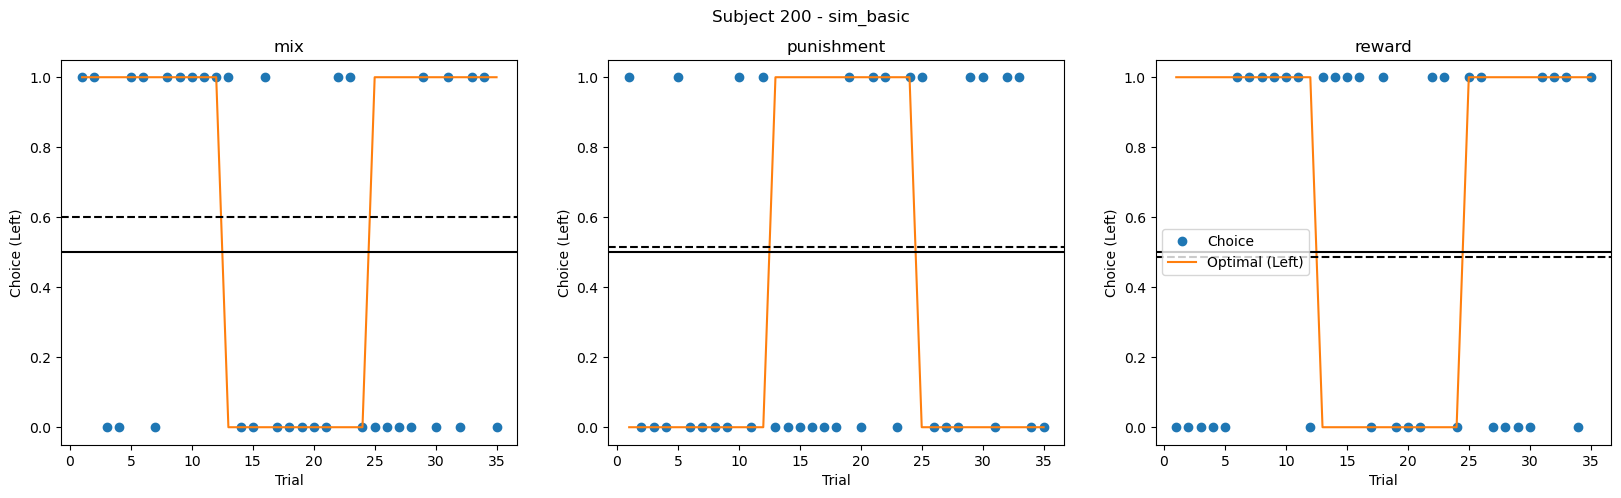

In [8]:
plot_subject(sub_df, subject, mod)

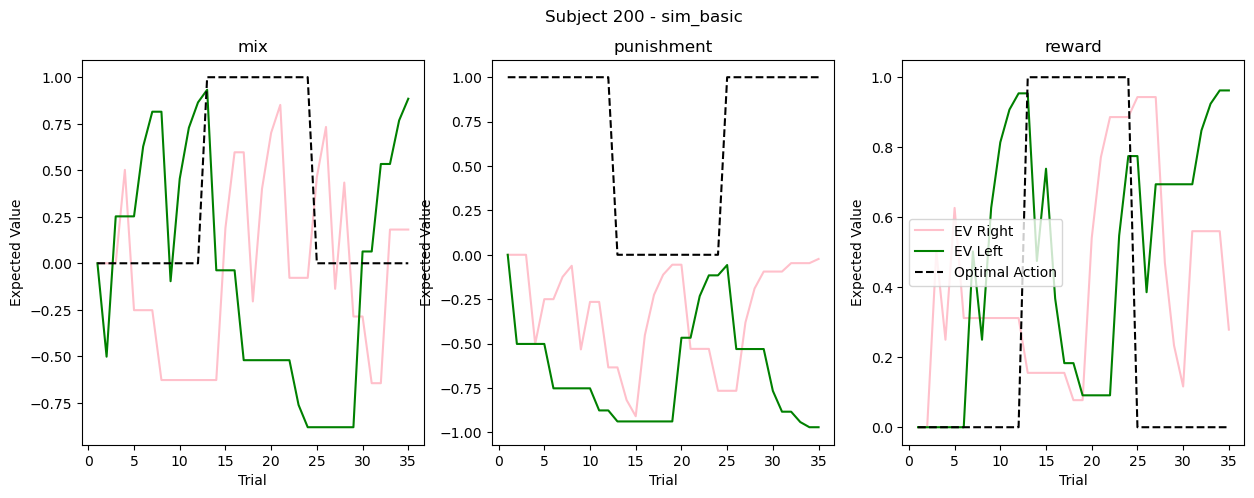

In [9]:
# plot ev_l and ev_r for a subject
def plot_ev(sub_df, subject, model):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        block_df = sub_df[sub_df['block']==i]
        ax.plot(block_df['trial'], block_df['ev_r'], '-', color='pink')
        ax.plot(block_df['trial'], block_df['ev_l'], '-', color='green')
        ax.plot(block_df['trial'], block_df['opt_act'], '--', color='black')
        ax.set_title(block_df['block_type'].iloc[0])
        ax.set_xlabel('Trial')
        ax.set_ylabel('Expected Value')
    
    axs[-1].legend(['EV Right', 'EV Left', 'Optimal Action'])
    plt.suptitle(f'Subject {subject} - {model["model"][0]}')

plot_ev(sub_df, subject, mod)

In [10]:
def plot_optimal(sim_df):
    sim_sub_level = sim_df.groupby(['subject', 'block_type'])['optimal'].mean().reset_index()
    sns.boxplot(data=sim_sub_level, x='block_type', y='optimal')
    sns.lineplot(data=sim_sub_level, x='block_type', y='optimal', color='red', errorbar=('se', 1))
    plt.axhline(0.5, color='black', linestyle='-')
    plt.xlabel('block')
    plt.title(sim_df['model'][0])
    sns.despine()

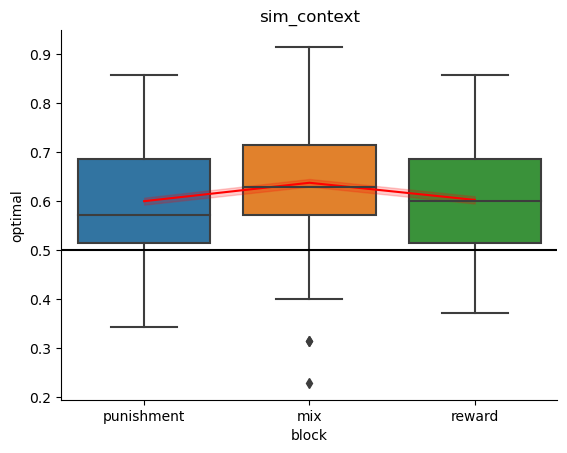

In [31]:
plot_optimal(sim_context)

In [21]:
# visualize optimal choice as a function of learning rate
def plot_optimal_lr(sim_df, param):
    sim_sub_level = sim_df.groupby(['subject', 'block_type', param])['optimal'].mean().reset_index()
    sns.lineplot(data=sim_sub_level, x=param, y='optimal', hue='block_type', errorbar=('se',1))
    plt.axhline(0.5, color='black', linestyle='-')
    plt.xlabel(param)
    plt.title(sim_df['model'][0])
    sns.despine()

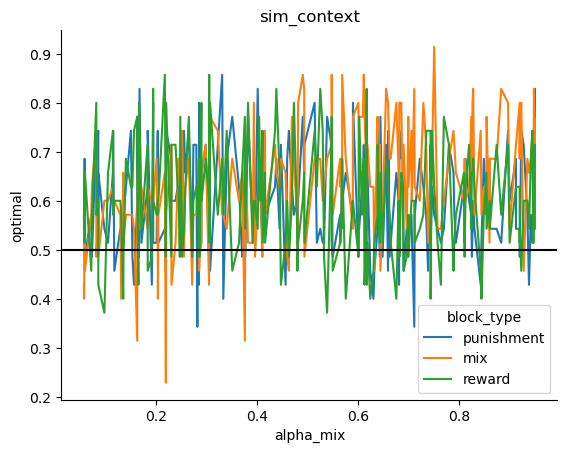

In [34]:
plot_optimal_lr(sim_context, 'alpha_mix')

In [41]:
# Specific sequence to match
mod_df = sim_context

target_sequence = mod_df['opt_act'][0:35].to_list()
grouped = mod_df.groupby(['subject', 'block'])

# Define a function to check if a block matches the target sequence
def match_sequence(group):
    # Sort by trial if necessary
    group_sorted = group.sort_values(by='trial')
    # Check if the 'optimal_sequence' column matches the target sequence
    return np.array_equal(group_sorted['opt_act'].values, target_sequence)

# Apply the filtering function to each group and filter only matching groups
matching_reversal = grouped.filter(match_sequence)
matching_reversal

,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,alpha_opt,alpha_pes,alpha_mix,beta,ev_l,ev_r,model,block_type,optimal_L,optimal
0,0,0,0,1,0.0,-1.0,1.0,numberbar_mixed,-1.000000,0.500000,0.878905,0.861318,0.810217,2.054012,0.000000,0.000000,sim_context,mix,0,1
1,0,0,1,0,1.0,-1.0,1.0,numberbar_mixed,-1.000000,0.840800,0.878905,0.861318,0.810217,2.054012,0.000000,-0.810217,sim_context,mix,0,0
2,0,0,2,1,0.0,1.0,1.0,numberbar_mixed,1.810217,0.500000,0.878905,0.861318,0.810217,2.054012,-0.810217,-0.810217,sim_context,mix,0,1
3,0,0,3,1,0.0,1.0,1.0,numberbar_mixed,0.343548,0.953138,0.878905,0.861318,0.810217,2.054012,-0.810217,0.656452,sim_context,mix,0,1
4,0,0,4,1,0.0,-1.0,1.0,numberbar_mixed,-1.934801,0.972993,0.878905,0.861318,0.810217,2.054012,-0.810217,0.934801,sim_context,mix,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22920,218,0,30,0,1.0,-1.0,1.0,numberbar_mixed,-1.620467,0.665649,0.503824,0.093373,0.549094,1.351078,0.620467,0.110821,sim_context,mix,0,0
22921,218,0,31,1,0.0,1.0,1.0,numberbar_mixed,0.889179,0.625650,0.503824,0.093373,0.549094,1.351078,-0.269322,0.110821,sim_context,mix,0,1
22922,218,0,32,1,0.0,1.0,1.0,numberbar_mixed,0.400936,0.763733,0.503824,0.093373,0.549094,1.351078,-0.269322,0.599064,sim_context,mix,0,1
22923,218,0,33,1,0.0,1.0,1.0,numberbar_mixed,0.180785,0.813164,0.503824,0.093373,0.549094,1.351078,-0.269322,0.819215,sim_context,mix,0,1


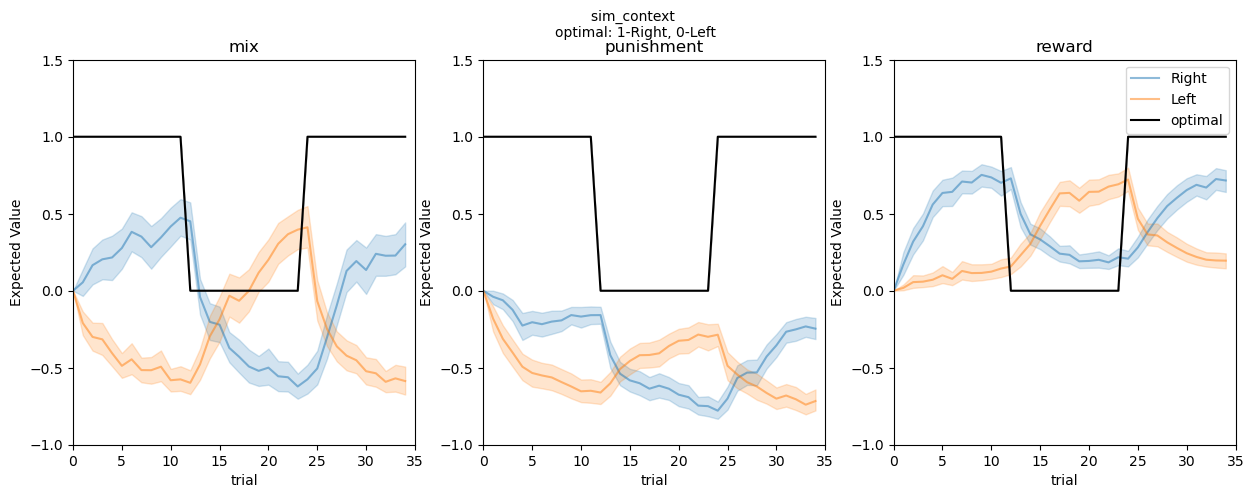

In [42]:
# make the above plot to loop through all blocks in subplots

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, b in enumerate(matching_reversal['block_type'].unique()):    
    df_block = matching_reversal[matching_reversal.block_type == b]
    sns.lineplot(data=df_block, x='trial', y='ev_r', legend=False, alpha=0.5, label='Right', ax=ax[i])
    sns.lineplot(data=df_block, x='trial', y='ev_l', legend=False, alpha=0.5, label='Left', ax=ax[i])
    sns.lineplot(data=df_block, x='trial', y='opt_act', legend=False, label='optimal', color='black', ax=ax[i])
    ax[i].set_ylabel('Expected Value')
    ax[i].set_title(b)
    ax[i].set_ylim(-1, 1.5)
    ax[i].set_xlim(0, 35)

mod_name = matching_reversal['model'][0]
plt.suptitle(f'{mod_name} \noptimal: 1-Right, 0-Left', fontsize=10)
plt.legend()